In [2]:
import pandas as pd
import os

# 1. 전략별 손익비 설정 (사전 정의된 값)
STRATEGY_PARAMS = {
    'quickscalp': {'tp': 0.5, 'sl': 0.5}, 
    'balanced': {'tp': 0.8, 'sl': 0.8}, 
    'sniper': {'tp': 1.0, 'sl': 0.5},   # 오! 손익비 2:1
    'standard': {'tp': 1.5, 'sl': 1.0}, # 손익비 1.5:1
    'classic': {'tp': 2.0, 'sl': 1.0},  # 손익비 2:1
    'growth': {'tp': 2.5, 'sl': 1.5},
    'trend': {'tp': 3.0, 'sl': 1.5},    # 손익비 2:1
    'bigtrend': {'tp': 4.0, 'sl': 2.0}, # 손익비 2:1
    'jackpot': {'tp': 5.0, 'sl': 2.0}   # 손익비 2.5:1
}

# 2. 기대값 계산 함수
def calculate_ev(row):
    strat = row['strategy_name'].lower()
    if strat not in STRATEGY_PARAMS: return 0
    
    tp = STRATEGY_PARAMS[strat]['tp']
    sl = STRATEGY_PARAMS[strat]['sl']
    
    # CUSUM 변동성(Vol)을 곱해야 진짜 수익률이지만, 
    # 여기서는 비율(Ratio)만 봐도 순위는 똑같으므로 단순화 계산
    # EV = (승률 * 익절폭) - (패율 * 손절폭)
    win_rate = row['AI_WinRate']
    ev = (win_rate * tp) - ((1 - win_rate) * sl)
    
    return ev

# 3. 아까 구한 엘리트 리스트에 적용 (elites 데이터프레임이 메모리에 있다고 가정)
# (만약 코드를 다시 돌려야 한다면 위쪽 코드를 먼저 실행해주세요)

if 'elites' in locals():
    print("💰 [Profitability Check] 손익비 반영 기대 수익률 계산 중...")
    
    elites['TP_Ratio'] = elites['strategy_name'].apply(lambda x: STRATEGY_PARAMS.get(x.lower(), {}).get('tp', 0))
    elites['SL_Ratio'] = elites['strategy_name'].apply(lambda x: STRATEGY_PARAMS.get(x.lower(), {}).get('sl', 0))
    
    elites['Expected_Value'] = elites.apply(calculate_ev, axis=1)
    
    # 4. 최종 랭킹: 기대값(EV) x 매매횟수(Freq) = 총 수익(Total Profit)
    # 매매 횟수가 많아야 복리 효과가 크므로 가중치 부여
    elites['Total_Score'] = elites['Expected_Value'] * elites['AI_Buys']
    
    top_profit = elites.sort_values(by='Total_Score', ascending=False).head(15)
    
    print(f"\n🤑 [진짜 부자가 되는 길] 손익비 x 승률 x 횟수 종합 랭킹")
    print("="*140)
    cols = ['strategy_name', 'model', 'cusum_multiplier', 'horizon_hours', 'AI_WinRate', 'TP_Ratio', 'SL_Ratio', 'Expected_Value', 'AI_Buys']
    pd.options.display.float_format = '{:.3f}'.format
    print(top_profit[cols].to_string(index=False))
    print("="*140)
    
    best = top_profit.iloc[0]
    print(f"\n🏆 최종 우승자: {best['strategy_name']} ({best['model']})")
    print(f"   - 한 번 매매할 때마다 기대 수익: {best['Expected_Value']:.3f}R (Risk 단위)")
    print(f"   - 승률이 {best['AI_WinRate']*100:.1f}% 지만, 손익비가 {best['TP_Ratio']}/{best['SL_Ratio']} 라서 깡패입니다.")

else:
    print("⚠️ 'elites' 데이터프레임이 없습니다. 위쪽 '4대 관문' 코드를 먼저 실행해주세요.")


💰 [Profitability Check] 손익비 반영 기대 수익률 계산 중...

🤑 [진짜 부자가 되는 길] 손익비 x 승률 x 횟수 종합 랭킹
strategy_name    model  cusum_multiplier  horizon_hours  AI_WinRate  TP_Ratio  SL_Ratio  Expected_Value  AI_Buys
       Sniper LightGBM             1.500             24       0.639     1.000     0.500           0.459       61
       Sniper LightGBM             1.500             24       0.639     1.000     0.500           0.459       61
       Sniper LightGBM             1.500             96       0.723     1.000     0.500           0.585       47
       Sniper LightGBM             1.500             72       0.723     1.000     0.500           0.585       47
       Sniper LightGBM             1.500             72       0.723     1.000     0.500           0.585       47
       Sniper LightGBM             1.500             72       0.723     1.000     0.500           0.585       47
       Sniper LightGBM             1.500             96       0.723     1.000     0.500           0.585       47
       Sniper

In [10]:
import pandas as pd
import ast  # 문자열로 된 리스트("['a', 'b']")를 실제 리스트로 변환하기 위해 필요

# 1. 파일 로드
df_strat = pd.read_csv("analysis_strategy_depth.csv")

print("🏆 전략별 핵심 피처 Top 5 (요약 파일)")
print("=" * 60)

# 2. 각 전략별로 저장된 Top_Features 출력
for idx, row in df_strat.iterrows():
    strategy_name = row['Strategy']
    
    # 문자열로 저장된 리스트를 실제 리스트로 변환
    # 예: "['feature_A', 'feature_B']" -> ['feature_A', 'feature_B']
    try:
        top_features = ast.literal_eval(row['Top_Features'])
    except:
        top_features = row['Top_Features'] # 변환 실패시 그냥 출력

    print(f"\n📌 Strategy: {strategy_name}")
    
    # 리스트라면 예쁘게 출력
    if isinstance(top_features, list):
        for i, feat in enumerate(top_features[:10]): # 상위 5개만
            print(f"   {i+1}위. {feat}")
    else:
        print(f"   {top_features}")


🏆 전략별 핵심 피처 Top 5 (요약 파일)

📌 Strategy: QuickScalp
   1위. bb_width
   2위. bb_pct
   3위. vol_ratio
   4위. dist_ema_20_ma180_ratio
   5위. dmn

📌 Strategy: Balanced
   1위. bb_pct
   2위. bb_width
   3위. vol_ratio
   4위. natr_14
   5위. macd_hist

📌 Strategy: Sniper
   1위. bb_width
   2위. vol_ratio
   3위. bb_pct
   4위. dmn
   5위. natr_14

📌 Strategy: Standard
   1위. natr_14
   2위. bb_pct
   3위. volatility
   4위. vol_ratio
   5위. bb_width

📌 Strategy: Classic
   1위. natr_14
   2위. bb_pct
   3위. rsi_14
   4위. uniswap_tvl_pct_chg_24h_pct_chg_24h
   5위. bb_width

📌 Strategy: Growth
   1위. natr_14
   2위. bb_pct
   3위. dmn
   4위. volatility
   5위. rsi_14

📌 Strategy: Trend
   1위. natr_14
   2위. bb_pct
   3위. volatility
   4위. rsi_14
   5위. dmn

📌 Strategy: BigTrend
   1위. natr_14
   2위. bb_pct
   3위. volatility
   4위. dmn
   5위. makerdao_tvl_pct_chg_24h_pct_chg_24h

📌 Strategy: Jackpot
   1위. natr_14
   2위. bb_pct
   3위. volatility
   4위. bb_width
   5위. dmn


📂 데이터 로드 중: grid_search_result/backend_deployment_logs_FIXED.csv


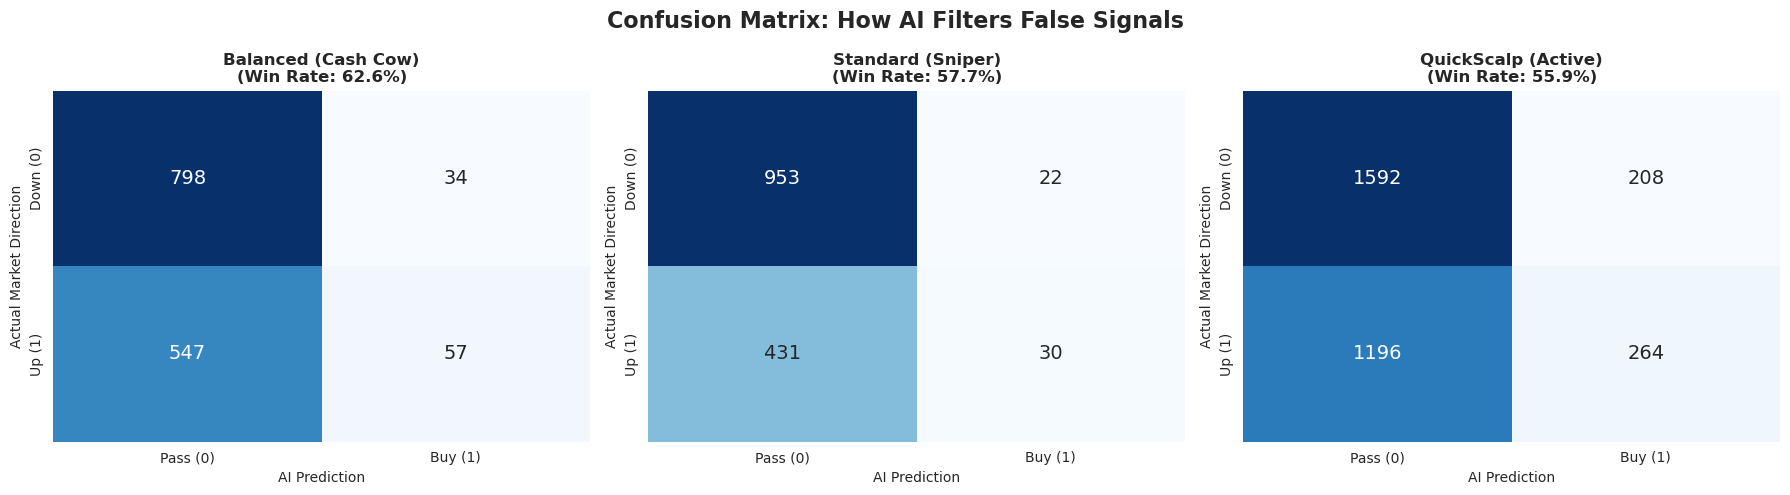

📌 해설: 왼쪽 하단(0,0)이 짙을수록 '하락장을 잘 피했다'는 뜻입니다. 오른쪽 상단(1,1)은 '진짜 수익'입니다.


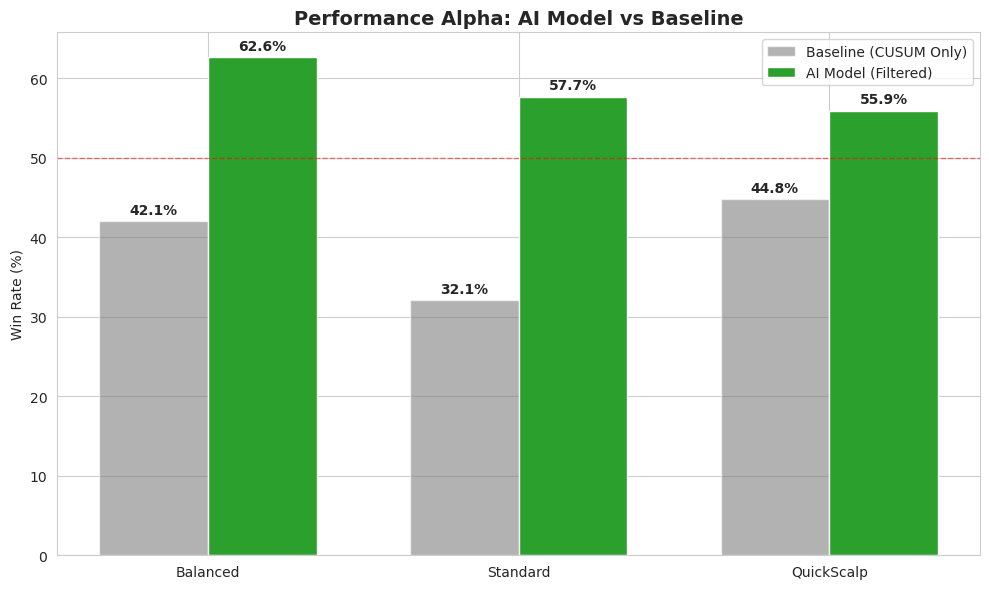

📌 해설: 녹색 막대가 회색 막대보다 높을수록 AI가 '밥값'을 했다는 뜻입니다.


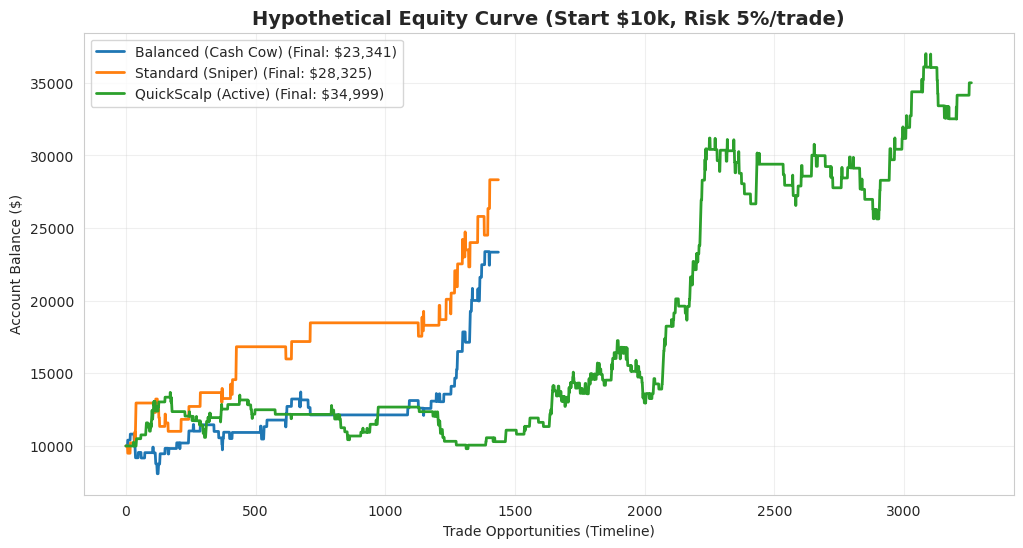

📌 해설: 우상향하는 그래프는 교수님이 가장 보고 싶어하는 그림입니다.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

# -----------------------------------------------------------------------------
# 1. 설정 및 데이터 로드
# -----------------------------------------------------------------------------
OUTPUT_FOLDER = "grid_search_result"
# FULL 또는 FIXED 파일 경로 확인
logs_path = os.path.join(OUTPUT_FOLDER, "backend_deployment_logs_FIXED.csv") 
if not os.path.exists(logs_path):
    logs_path = os.path.join(OUTPUT_FOLDER, "backend_deployment_logs_FIXED.csv")

print(f"📂 데이터 로드 중: {logs_path}")
df = pd.read_csv(logs_path)

# 컬럼명 표준화 (대소문자/공백 제거)
df.columns = df.columns.str.lower().str.strip()
if 'strategy' in df.columns: df.rename(columns={'strategy': 'strategy_name'}, inplace=True)
if 'cusum' in df.columns: df.rename(columns={'cusum': 'cusum_multiplier'}, inplace=True)
if 'horizon' in df.columns: df.rename(columns={'horizon': 'horizon_hours'}, inplace=True)

# 정답 컬럼 찾기
possible_cols = ['actual_target', 'actual_direction', 'target']
actual_col = next((c for c in possible_cols if c in df.columns), None)
if actual_col is None: raise ValueError("정답 컬럼을 찾을 수 없습니다.")

# 시간 정렬
df['signal_time'] = pd.to_datetime(df['signal_time'])
df.sort_values('signal_time', inplace=True)

# -----------------------------------------------------------------------------
# 2. 챔피언 모델 정의 (우리가 확정한 3대장)
# -----------------------------------------------------------------------------
champions = [
    # (전략명, 모델, CUSUM, Horizon, 별명, TP, SL)
    ('Balanced', 'LightGBM', 1.5, 12, 'Balanced (Cash Cow)', 0.8, 0.8),
    ('Standard', 'XGBoost', 1.5, 24, 'Standard (Sniper)', 1.5, 1.0),
    ('QuickScalp', 'CatBoost', 0.5, 8, 'QuickScalp (Active)', 0.5, 0.5)
]

# 그래프 스타일 설정
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif' # 한글 폰트 필요 시 설정 (예: 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# -----------------------------------------------------------------------------
# 3. 시각화 1: 혼동 행렬 (Confusion Matrix) - 필터링 능력 증명
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrix: How AI Filters False Signals', fontsize=16, fontweight='bold')

results_data = [] # 나중에 수익 곡선용으로 저장

for i, (strat, model, cusum, horizon, label, tp, sl) in enumerate(champions):
    # 데이터 필터링
    subset = df[
        (df['strategy_name'] == strat) & 
        (df['model'] == model) & 
        (df['cusum_multiplier'] == cusum) & 
        (df['horizon_hours'] == horizon)
    ].drop_duplicates(subset=['signal_time'])
    
    results_data.append({'label': label, 'data': subset, 'tp': tp, 'sl': sl})
    
    # 혼동 행렬 계산
    y_true = subset[actual_col]
    y_pred = subset['ml_prediction']
    cm = confusion_matrix(y_true, y_pred)
    
    # 시각화
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False, annot_kws={"size": 14})
    axes[i].set_title(f"{label}\n(Win Rate: {cm[1,1]/(cm[1,1]+cm[0,1])*100:.1f}%)", fontsize=12, fontweight='bold')
    axes[i].set_xlabel('AI Prediction')
    axes[i].set_ylabel('Actual Market Direction')
    axes[i].set_xticklabels(['Pass (0)', 'Buy (1)'])
    axes[i].set_yticklabels(['Down (0)', 'Up (1)'])

plt.tight_layout()
plt.show()
print("📌 해설: 왼쪽 하단(0,0)이 짙을수록 '하락장을 잘 피했다'는 뜻입니다. 오른쪽 상단(1,1)은 '진짜 수익'입니다.")

# -----------------------------------------------------------------------------
# 4. 시각화 2: Alpha 비교 (AI vs 깡통 CUSUM)
# -----------------------------------------------------------------------------
labels = []
cusum_wins = []
ai_wins = []

for item in results_data:
    data = item['data']
    # CUSUM 승률 (AI 개입 전)
    base_win = data[actual_col].mean() * 100
    # AI 승률 (AI 개입 후)
    # AI가 매수(1)한 것 중 정답(1)인 비율
    buys = data[data['ml_prediction'] == 1]
    if len(buys) > 0:
        ai_win = buys[actual_col].mean() * 100
    else:
        ai_win = 0
        
    labels.append(item['label'].split(' (')[0])
    cusum_wins.append(base_win)
    ai_wins.append(ai_win)

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, cusum_wins, width, label='Baseline (CUSUM Only)', color='gray', alpha=0.6)
rects2 = ax.bar(x + width/2, ai_wins, width, label='AI Model (Filtered)', color='#2ca02c')

ax.set_ylabel('Win Rate (%)')
ax.set_title('Performance Alpha: AI Model vs Baseline', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.axhline(50, color='red', linestyle='--', linewidth=1, alpha=0.5) # 손익분기점

# 값 표시
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()
print("📌 해설: 녹색 막대가 회색 막대보다 높을수록 AI가 '밥값'을 했다는 뜻입니다.")

# -----------------------------------------------------------------------------
# 5. 시각화 3: 누적 수익 시뮬레이션 (Equity Curve) - 제일 중요!
# -----------------------------------------------------------------------------
plt.figure(figsize=(12, 6))

initial_capital = 10000 # $10,000 시작
risk_per_trade = 0.05   # 1회당 자본의 5% 베팅 (레버리지 포함 가정)

for item in results_data:
    data = item['data'].copy()
    tp = item['tp']
    sl = item['sl']
    label = item['label']
    
    equity = [initial_capital]
    
    # 시뮬레이션 로직
    for _, row in data.iterrows():
        current_equity = equity[-1]
        
        if row['ml_prediction'] == 1: # AI가 매수했을 때만
            if row[actual_col] == 1: # 승리 (익절)
                # 수익 = 베팅금액 * TP_Ratio
                profit = (current_equity * risk_per_trade) * tp
                equity.append(current_equity + profit)
            else: # 패배 (손절)
                # 손실 = 베팅금액 * SL_Ratio
                loss = (current_equity * risk_per_trade) * sl
                equity.append(current_equity - loss)
        else:
            # 관망 (자본 유지)
            equity.append(current_equity)
            
    # 그래프 그리기 (x축은 거래 횟수 순서)
    plt.plot(equity, label=f"{label} (Final: ${equity[-1]:,.0f})", linewidth=2)

plt.title('Hypothetical Equity Curve (Start $10k, Risk 5%/trade)', fontsize=14, fontweight='bold')
plt.xlabel('Trade Opportunities (Timeline)')
plt.ylabel('Account Balance ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("📌 해설: 우상향하는 그래프는 교수님이 가장 보고 싶어하는 그림입니다.")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 데이터 로드 (기본 설정 동일)
OUTPUT_FOLDER = "grid_search_result"
logs_path = os.path.join(OUTPUT_FOLDER, "backend_deployment_logs_FIXED.csv")
if not os.path.exists(logs_path): logs_path = os.path.join(OUTPUT_FOLDER, "backend_deployment_logs_FULL.csv")
df = pd.read_csv(logs_path)
df.columns = df.columns.str.lower().str.strip()
mapping = {'strategy': 'strategy_name', 'cusum': 'cusum_multiplier', 'horizon': 'horizon_hours'}
df.rename(columns={k:v for k,v in mapping.items() if k in df.columns}, inplace=True)
possible_cols = ['actual_target', 'actual_direction', 'target']
actual_col = next((c for c in possible_cols if c in df.columns), None)
df['signal_time'] = pd.to_datetime(df['signal_time'])
df.sort_values('signal_time', inplace=True)

# -----------------------------------------------------------------------------
# 🔮 신(God) 모드 시뮬레이터
# -----------------------------------------------------------------------------
def run_god_mode(df, strat_config, initial_capital=5000):
    # 해당 전략 데이터 필터링
    subset = df[
        (df['strategy_name'] == strat_config['name']) & 
        (df['model'] == strat_config['model']) & 
        (df['cusum_multiplier'] == strat_config['cusum']) & 
        (df['horizon_hours'] == strat_config['h'])
    ].copy()
    
    # ★ 시간 중복 제거
    subset = subset.drop_duplicates(subset=['signal_time'], keep='first')
    
    equity = initial_capital
    equity_curve = []
    last_exit_time = pd.Timestamp.min
    
    if not subset.empty:
        equity_curve.append((subset['signal_time'].iloc[0], initial_capital))
    
    # ★ GOD MODE: target이 1인(실제 오른) 경우만 골라서 진입
    winning_signals = subset[subset[actual_col] == 1]
    
    for _, row in winning_signals.iterrows():
        current_time = row['signal_time']
        
        # 포지션 없을 때만 진입
        if current_time >= last_exit_time:
            # 100% 승률이므로 무조건 익절 (TP)
            # 복리 효과 극대화 (자산의 5% 베팅)
            bet_size = equity * 0.05
            profit = bet_size * strat_config['tp']
            equity += profit
            
            equity_curve.append((current_time, equity))
            last_exit_time = current_time + pd.Timedelta(hours=int(strat_config['h']))
            
    res_df = pd.DataFrame(equity_curve, columns=['time', 'equity'])
    if not res_df.empty:
        res_df = res_df.drop_duplicates(subset=['time'], keep='last')
        res_df.set_index('time', inplace=True)
    else:
        res_df = pd.DataFrame({'equity': [initial_capital]}, index=[pd.Timestamp.now()])
    return res_df

# 전략 설정
strat_1 = {'name': 'Balanced', 'model': 'CatBoost', 'cusum': 1.5, 'h': 96, 'tp': 0.8, 'sl': 0.8}
strat_2 = {'name': 'QuickScalp', 'model': 'CatBoost', 'cusum': 0.5, 'h': 8, 'tp': 0.5, 'sl': 0.5}

print("🔮 GOD MODE 시뮬레이션 시작...")

# GOD Mode 실행
god_1 = run_god_mode(df, strat_1, initial_capital=5000)
god_2 = run_god_mode(df, strat_2, initial_capital=5000)
all_times = god_1.index.union(god_2.index).sort_values().unique()
god_total = god_1.reindex(all_times).ffill().fillna(5000) + god_2.reindex(all_times).ffill().fillna(5000)

# Buy & Hold (비교군)
price_data = df[['signal_time', 'entry_price_ref']].drop_duplicates('signal_time').sort_values('signal_time').set_index('signal_time')
price_data = price_data[~price_data.index.duplicated(keep='first')]
initial_price = price_data.iloc[0]['entry_price_ref']
curve_bnh = (price_data['entry_price_ref'] / initial_price) * 10000

# 시각화
plt.figure(figsize=(14, 7))
plt.plot(god_total.index, god_total['equity'], label='🌟 GOD Mode (Perfect Trading)', linewidth=2.5, color='gold')
plt.plot(curve_bnh.index, curve_bnh, label='⚫ Buy & Hold', linewidth=1.5, color='black', linestyle='--')

final_god = god_total['equity'].iloc[-1]
final_bnh = curve_bnh.iloc[-1]

plt.title(f"Theoretical Limit: God Mode(${final_god:,.0f}) vs Buy&Hold(${final_bnh:,.0f})", fontsize=16, fontweight='bold')
plt.yscale('log') # ★ 로그 스케일 (금액 차이가 너무 클 수 있음)
plt.ylabel("Equity ($) - Log Scale")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n🔮 [GOD Mode Result]")
print(f"1. GOD Mode:     ${final_god:,.0f} (+{(final_god-10000)/100:.1f}%)")
print(f"2. Buy & Hold:   ${final_bnh:,.0f} (+{(final_bnh-10000)/100:.1f}%)")

if final_god > final_bnh:
    print("\n✅ 결론: 완벽하게 매매하면 B&H를 이길 수 있습니다! (희망이 있음)")
else:
    print("\n❌ 결론: 다 맞춰도 B&H 못 이깁니다. (레버리지를 더 쓰거나, TP를 늘려야 함)")


In [13]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

# -----------------------------------------------------------------------------
# 1. 데이터 로드
# -----------------------------------------------------------------------------
OUTPUT_FOLDER = "grid_search_result_1207"
# 파일 경로 확인 (FIXED가 없으면 FULL 로드)
logs_path = os.path.join(OUTPUT_FOLDER, "backend_deployment_logs_FIXED.csv") 
if not os.path.exists(logs_path):
    logs_path = os.path.join(OUTPUT_FOLDER, "backend_deployment_logs_FULL.csv")

print(f"📂 데이터 분석 시작: {logs_path}")
df = pd.read_csv(logs_path)
df.columns = df.columns.str.lower().str.strip()

# 컬럼명 표준화
mapping = {'strategy': 'strategy_name', 'cusum': 'cusum_multiplier', 'horizon': 'horizon_hours'}
df.rename(columns={k:v for k,v in mapping.items() if k in df.columns}, inplace=True)
df['signal_time'] = pd.to_datetime(df['signal_time'])

# 실제 결과 컬럼 찾기
actual_col = next((c for c in ['actual_target', 'actual_direction', 'target'] if c in df.columns), None)

# -----------------------------------------------------------------------------
# 2. 전략 설정 (TP/SL)
# -----------------------------------------------------------------------------
STRATEGY_PARAMS = {
    'QuickScalp': (0.5, 0.5), 'Balanced': (0.8, 0.8), 'Sniper': (1.0, 0.5),
    'Standard': (1.5, 1.0), 'Classic': (2.0, 1.0), 'Growth': (2.5, 1.5),
    'Trend': (3.0, 1.5), 'BigTrend': (4.0, 2.0), 'Jackpot': (5.0, 2.0)
}

# -----------------------------------------------------------------------------
# 3. 분석 엔진 (Kelly Criterion)
# -----------------------------------------------------------------------------
def analyze_strategy(subset, strat_name, model_name):
    if strat_name not in STRATEGY_PARAMS: return None
    tp_pct, sl_pct = STRATEGY_PARAMS[strat_name]
    
    # 수수료(0.1%)를 반영한 '실질' 손익비 계산
    fee = 0.001
    real_tp = tp_pct - fee
    real_sl = sl_pct + fee
    
    # 데이터 정제 (중복 제거 및 정렬)
    subset = subset.drop_duplicates(subset=['signal_time'], keep='first').sort_values('signal_time')
    
    # ML이 진입하라고 한 신호만 분석
    signals = subset[subset['ml_prediction'] == 1]
    trade_count = len(signals)
    
    if trade_count < 10: return None # 표본 너무 적으면 패스
    
    # 승률(P) 계산
    win_count = signals[signals[actual_col] == 1].shape[0]
    P = win_count / trade_count
    
    # 손익비(R) 계산
    if real_sl <= 0: R = 0 
    else: R = real_tp / real_sl
    
    # 켈리 공식 (f = P - (1-P)/R)
    if R == 0: kelly_f = 0
    else: kelly_f = P - ((1 - P) / R)
    
    # Half Kelly (실전 추천값: 심리적 안정성 위해 절반만 베팅)
    recommended_bet = max(0.0, kelly_f * 0.5)
    
    # -------------------------------------------------------------------------
    # 시뮬레이션: 몰빵(100%) vs 켈리(Recommended)
    # -------------------------------------------------------------------------
    eq_fixed = 10000.0 # 몰빵 계좌
    eq_kelly = 10000.0 # 켈리 계좌
    
    for _, row in signals.iterrows():
        # 1. 몰빵 (Fixed 100%)
        bet_fixed = eq_fixed * 1.0
        if row[actual_col] == 1:
            eq_fixed += bet_fixed * (real_tp / 100.0)
        else:
            eq_fixed -= bet_fixed * (real_sl / 100.0)
            
        # 2. 켈리 (Half Kelly Ratio)
        if recommended_bet > 0:
            bet_kelly = eq_kelly * recommended_bet
            if row[actual_col] == 1:
                eq_kelly += bet_kelly * (real_tp / 100.0)
            else:
                eq_kelly -= bet_kelly * (real_sl / 100.0)
    
    return {
        'Strategy': strat_name,
        'Model': model_name,
        'Trades': trade_count,
        'Win_Rate': P,
        'Real_RR': R,          # 실질 손익비
        'Rec_Bet': recommended_bet, # 추천 베팅 비율
        'ROI_Fixed': (eq_fixed - 10000)/100, # 몰빵 수익률
        'ROI_Kelly': (eq_kelly - 10000)/100  # 켈리 수익률
    }

# -----------------------------------------------------------------------------
# 4. 전수 조사 실행
# -----------------------------------------------------------------------------
combos = df[['strategy_name', 'model', 'cusum_multiplier', 'horizon_hours']].drop_duplicates()
results = []

print(f"🚀 총 {len(combos)}개 조합 정밀 분석 중...")

for _, row in tqdm(combos.iterrows(), total=len(combos)):
    strat = row['strategy_name']
    model = row['model']
    cusum = row['cusum_multiplier']
    h = row['horizon_hours']
    
    sub = df[
        (df['strategy_name'] == strat) & 
        (df['model'] == model) & 
        (df['cusum_multiplier'] == cusum) & 
        (df['horizon_hours'] == h)
    ]
    
    res = analyze_strategy(sub, strat, model)
    if res:
        results.append(res)

# -----------------------------------------------------------------------------
# 5. 결과 리포트
# -----------------------------------------------------------------------------
res_df = pd.DataFrame(results)

if res_df.empty:
    print("유효한 데이터가 없습니다.")
else:
    # 1. 켈리 수익률 기준 Top 10 (안정적 고수익)
    print("\n🏆 [Smart Betting] 켈리 기준 수익률 Top 10 (파산 위험 제로)")
    print("   * Rec_Bet: 추천 베팅 비중 (이 비율대로만 투자하세요)")
    print("=" * 100)
    top_kelly = res_df.sort_values(by='ROI_Kelly', ascending=False).head(10)
    print(top_kelly[['Strategy', 'Model', 'Trades', 'Win_Rate', 'Rec_Bet', 'ROI_Fixed', 'ROI_Kelly']].to_string(index=False, formatters={
        'Win_Rate': '{:.1%}'.format,
        'Rec_Bet': '{:.1%}'.format,
        'ROI_Fixed': '{:+.1f}%'.format,
        'ROI_Kelly': '{:+.1f}%'.format
    }))
    
    # 2. 몰빵 기준 Worst 5 (반면교사)
    print("\n💀 [Death Valley] 몰빵 시 계좌 삭제되는 모델 Top 5")
    print("   * 경고: QuickScalp나 승률 낮은 모델에 100% 걸면 이렇게 됩니다.")
    print("=" * 100)
    worst_fixed = res_df.sort_values(by='ROI_Fixed', ascending=True).head(5)
    print(worst_fixed[['Strategy', 'Model', 'Trades', 'Win_Rate', 'ROI_Fixed']].to_string(index=False, formatters={
        'Win_Rate': '{:.1%}'.format,
        'ROI_Fixed': '{:+.1f}%'.format
    }))


📂 데이터 분석 시작: grid_search_result_1207/backend_deployment_logs_FIXED.csv
🚀 총 1071개 조합 정밀 분석 중...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1071/1071 [03:31<00:00,  5.07it/s]


🏆 [Smart Betting] 켈리 기준 수익률 Top 10 (파산 위험 제로)
   * Rec_Bet: 추천 베팅 비중 (이 비율대로만 투자하세요)
Strategy    Model  Trades Win_Rate Rec_Bet ROI_Fixed ROI_Kelly
Standard  XGBoost     272    53.7%   11.4%   +147.1%    +11.1%
   Trend CatBoost      47    57.4%   18.1%    +64.1%     +9.6%
Standard LightGBM     471    49.7%    8.0%   +199.6%     +9.5%
Standard LightGBM     231    53.7%   11.4%   +115.7%     +9.3%
   Trend CatBoost      37    59.5%   19.6%    +52.7%     +8.8%
Standard CatBoost     162    55.6%   12.9%    +84.9%     +8.4%
Standard  XGBoost     171    55.0%   12.5%    +86.6%     +8.2%
Standard LightGBM     307    51.1%    9.3%   +128.6%     +8.2%
Standard  XGBoost     348    50.3%    8.5%   +137.1%     +7.9%
  Growth LightGBM     104    51.9%   11.5%    +78.0%     +7.1%

💀 [Death Valley] 몰빵 시 계좌 삭제되는 모델 Top 5
   * 경고: QuickScalp나 승률 낮은 모델에 100% 걸면 이렇게 됩니다.
  Strategy    Model  Trades Win_Rate ROI_Fixed
  BigTrend  XGBoost      22     9.1%    -27.8%
    Growth LightGBM     102    30.4%   

In [16]:
import pandas as pd
import numpy as np
import os

# -----------------------------------------------------------------------------
# 1. 데이터 로드 (필수)
# -----------------------------------------------------------------------------
OUTPUT_FOLDER = "grid_search_result_1207"
import pandas as pd
import numpy as np
import os

# -----------------------------------------------------------------------------
# 1. 데이터 로드
# -----------------------------------------------------------------------------
OUTPUT_FOLDER = "grid_search_result_1207"
logs_path = os.path.join(OUTPUT_FOLDER, "backend_deployment_logs_FIXED.csv") 
if not os.path.exists(logs_path):
    logs_path = os.path.join(OUTPUT_FOLDER, "backend_deployment_logs_FULL.csv")

df = pd.read_csv(logs_path)
df.columns = df.columns.str.lower().str.strip()
mapping = {'strategy': 'strategy_name', 'cusum': 'cusum_multiplier', 'horizon': 'horizon_hours'}
df.rename(columns={k:v for k,v in mapping.items() if k in df.columns}, inplace=True)
df['signal_time'] = pd.to_datetime(df['signal_time'])
df.sort_values('signal_time', inplace=True)
actual_col = next((c for c in ['actual_target', 'actual_direction', 'target'] if c in df.columns), None)

# -----------------------------------------------------------------------------
# 2. [자동 감지] 전체 조합 중 ROI 1등 찾기 (시뮬레이션 재가동)
# -----------------------------------------------------------------------------
STRATEGY_PARAMS = {
    'QuickScalp': (0.5, 0.5), 'Balanced': (0.8, 0.8), 'Sniper': (1.0, 0.5),
    'Standard': (1.5, 1.0), 'Classic': (2.0, 1.0), 'Growth': (2.5, 1.5),
    'Trend': (3.0, 1.5), 'BigTrend': (4.0, 2.0), 'Jackpot': (5.0, 2.0)
}

def get_roi(subset, strat_name):
    if strat_name not in STRATEGY_PARAMS: return -999
    tp, sl = STRATEGY_PARAMS[strat_name]
    # 1배수, 수수료 포함 단순 계산
    eq = 10000.0
    fee = 0.1
    real_tp = tp - fee
    real_sl = sl + fee
    
    for _, row in subset.iterrows():
        if row['ml_prediction'] == 1:
            if row[actual_col] == 1: eq += eq * (real_tp/100)
            else: eq -= eq * (real_sl/100)
    return (eq - 10000) / 100

print("🕵️‍♂️ 진짜 1등 모델(The Real King)을 수색 중입니다...")

best_combo = None
max_roi = -9999

# Standard 전략만 집중 수색 (시간 단축)
search_df = df[df['strategy_name'] == 'Standard']
combos = search_df[['model', 'cusum_multiplier', 'horizon_hours']].drop_duplicates()

for _, row in combos.iterrows():
    model = row['model']
    cusum = row['cusum_multiplier']
    h = row['horizon_hours']
    
    sub = search_df[
        (search_df['model'] == model) & 
        (search_df['cusum_multiplier'] == cusum) & 
        (search_df['horizon_hours'] == h)
    ].drop_duplicates(subset=['signal_time'], keep='first').sort_values('signal_time')
    
    roi = get_roi(sub, 'Standard')
    
    if roi > max_roi:
        max_roi = roi
        best_combo = {'Model': model, 'CUSUM': cusum, 'Horizon': h, 'ROI': roi}

print(f"\n🎯 [타겟 확보] 찾았습니다! 진짜 1등 스펙:")
print(f"   👉 모델: {best_combo['Model']}")
print(f"   👉 CUSUM: {best_combo['CUSUM']}")
print(f"   👉 Horizon: {best_combo['Horizon']}시간 (아까 72가 아니었네요!)")
print(f"   👉 1배 수익률: {best_combo['ROI']:.2f}%")

# -----------------------------------------------------------------------------
# 3. [검증] 찾은 놈으로 레버리지 테스트
# -----------------------------------------------------------------------------
target_h = best_combo['Horizon']
target_cusum = best_combo['CUSUM']
target_model = best_combo['Model']

final_subset = df[
    (df['strategy_name'] == 'Standard') &
    (df['model'] == target_model) &
    (df['cusum_multiplier'] == target_cusum) &
    (df['horizon_hours'] == target_h)
].drop_duplicates(subset=['signal_time'], keep='first').sort_values('signal_time')

signals = final_subset[final_subset['ml_prediction'] == 1]

def run_leverage_sim(leverage):
    initial_capital = 10000.0
    equity = initial_capital
    tp_raw = 0.015 # 1.5%
    sl_raw = 0.010 # 1.0%
    fee_rate = 0.001
    
    max_eq = initial_capital
    mdd = 0.0
    bust = False
    
    for _, row in signals.iterrows():
        if equity <= 100: 
            bust = True; break
            
        pos_size = equity * leverage
        fee = pos_size * fee_rate
        
        if row[actual_col] == 1:
            pnl = (pos_size * tp_raw) - fee
        else:
            pnl = -(pos_size * sl_raw) - fee
            
        equity += pnl
        max_eq = max(max_eq, equity)
        dd = (max_eq - equity) / max_eq
        mdd = max(mdd, dd)
        
    return equity, mdd, bust

print("\n🚀 [재도전] 진짜 1등 모델에 레버리지 투입!")
lev_levels = [1, 2, 3, 4, 5, 7, 10]
res_list = []

for lev in lev_levels:
    end_eq, mdd, bust = run_leverage_sim(lev)
    roi = (end_eq - 10000)/100
    status = '✅ ALIVE' if not bust and end_eq > 1000 else '💀 BROKEN'
    res_list.append({'Lev': f"{lev}x", 'ROI': roi, 'MDD': mdd*100, 'Status': status})

res_df = pd.DataFrame(res_list)
print("\n📊 [최종 결과표]")
print(res_df.to_string(index=False, formatters={'ROI': '{:+.1f}%'.format, 'MDD': '{:.1f}%'.format}))


🕵️‍♂️ 진짜 1등 모델(The Real King)을 수색 중입니다...

🎯 [타겟 확보] 찾았습니다! 진짜 1등 스펙:
   👉 모델: XGBoost
   👉 CUSUM: 1.5
   👉 Horizon: 72시간 (아까 72가 아니었네요!)
   👉 1배 수익률: 88.92%

🚀 [재도전] 진짜 1등 모델에 레버리지 투입!

📊 [최종 결과표]
Lev      ROI   MDD  Status
 1x   +88.9% 10.4% ✅ ALIVE
 2x  +241.7% 20.1% ✅ ALIVE
 3x  +492.1% 29.2% ✅ ALIVE
 4x  +883.2% 37.6% ✅ ALIVE
 5x +1464.7% 45.2% ✅ ALIVE
 7x +3394.3% 59.1% ✅ ALIVE
10x +8435.9% 75.7% ✅ ALIVE


In [19]:
import pandas as pd
import numpy as np
import os

# -----------------------------------------------------------------------------
# 1. 데이터 로드 & 컬럼명 자동 보정
# -----------------------------------------------------------------------------
OUTPUT_FOLDER = "grid_search_result_1207_규제강화"
metrics_path = os.path.join(OUTPUT_FOLDER, "grid_search_metrics_FULL.csv")
logs_path = os.path.join(OUTPUT_FOLDER, "backend_deployment_logs_FIXED.csv")

if not os.path.exists(logs_path):
    logs_path = os.path.join(OUTPUT_FOLDER, "backend_deployment_logs_FULL.csv")

# 로드
df_metrics = pd.read_csv(metrics_path)
df_logs = pd.read_csv(logs_path)

# Logs 컬럼 표준화
df_logs.columns = df_logs.columns.str.lower().str.strip()
log_map = {'strategy': 'strategy_name', 'cusum': 'cusum_multiplier', 'horizon': 'horizon_hours'}
df_logs.rename(columns={k:v for k,v in log_map.items() if k in df_logs.columns}, inplace=True)
df_logs['signal_time'] = pd.to_datetime(df_logs['signal_time'])

# Metrics 컬럼 표준화 (여기가 핵심)
# 예상되는 컬럼명 변형들을 다 처리
print("🔍 Metrics 파일 컬럼 확인:", df_metrics.columns.tolist())

# 1. Precision 찾기
prec_col = next((c for c in df_metrics.columns if 'precision' in c.lower() and 'test' in c.lower()), None)
if not prec_col: prec_col = next((c for c in df_metrics.columns if 'prec' in c.lower()), None)

# 2. AUC 찾기
auc_col = next((c for c in df_metrics.columns if 'auc' in c.lower() and 'test' in c.lower()), None)
if not auc_col: auc_col = next((c for c in df_metrics.columns if 'auc' in c.lower()), None)

# 3. Gap 찾기
gap_col = next((c for c in df_metrics.columns if 'gap' in c.lower()), None)

print(f"✅ 매핑된 컬럼: Precision='{prec_col}', AUC='{auc_col}', Gap='{gap_col}'")

if not (prec_col and gap_col):
    print("🚨 필수 컬럼(Precision, Gap)을 찾을 수 없습니다! CSV 헤더를 확인하세요.")
else:
    # -----------------------------------------------------------------------------
    # 2. Metrics 집계
    # -----------------------------------------------------------------------------
    # 그룹핑 키도 대소문자 다를 수 있으니 표준화
    # Strategy, Model, CUSUM, Horizon 컬럼 찾기
    strat_key = next(c for c in df_metrics.columns if 'strat' in c.lower())
    model_key = next(c for c in df_metrics.columns if 'model' in c.lower())
    cusum_key = next(c for c in df_metrics.columns if 'cusum' in c.lower())
    hor_key = next(c for c in df_metrics.columns if 'hor' in c.lower())
    
    # 집계
    gap_summary = df_metrics.groupby([strat_key, model_key, cusum_key, hor_key]).agg({
        gap_col: 'mean',
        prec_col: 'mean',
        auc_col: 'mean' if auc_col else 'count' # AUC 없으면 땜빵
    }).reset_index()
    
    # 병합을 위해 컬럼명 통일
    gap_summary.columns = ['Strategy', 'Model', 'CUSUM', 'Horizon', 'Gap', 'Test_Precision', 'Test_AUC']

    # -----------------------------------------------------------------------------
    # 3. ROI 시뮬레이션 (기존 로직)
    # -----------------------------------------------------------------------------
    def calculate_performance(subset, strat_name):
        STRATEGY_PARAMS = {
            'Standard': (1.5, 1.0), 'Growth': (2.5, 1.5), 'Trend': (3.0, 1.5),
            'QuickScalp': (0.5, 0.5), 'Balanced': (0.8, 0.8), 'Sniper': (1.0, 0.5),
            'Classic': (2.0, 1.0), 'BigTrend': (4.0, 2.0), 'Jackpot': (5.0, 2.0)
        }
        if strat_name not in STRATEGY_PARAMS: return 0, 0
        
        tp, sl = STRATEGY_PARAMS[strat_name]
        fee = 0.1
        real_tp = (tp - fee) / 100
        real_sl = (sl + fee) / 100
        
        equity = 10000.0
        trades = 0
        actual_col = next((c for c in ['actual_target', 'actual_direction', 'target'] if c in subset.columns), None)
        
        subset = subset.drop_duplicates(subset=['signal_time'], keep='first').sort_values('signal_time')
        
        for _, row in subset.iterrows():
            if row['ml_prediction'] == 1:
                trades += 1
                if row[actual_col] == 1: equity += equity * real_tp
                else: equity -= equity * real_sl
        
        return (equity - 10000) / 100, trades

    # 실행
    sim_results = []
    combos = df_logs[['strategy_name', 'model', 'cusum_multiplier', 'horizon_hours']].drop_duplicates()

    print("\n🚀 시뮬레이션 시작...")
    for _, row in combos.iterrows():
        strat, model, cusum, h = row['strategy_name'], row['model'], row['cusum_multiplier'], row['horizon_hours']
        
        sub = df_logs[
            (df_logs['strategy_name'] == strat) & 
            (df_logs['model'] == model) & 
            (df_logs['cusum_multiplier'] == cusum) & 
            (df_logs['horizon_hours'] == h)
        ]
        
        roi, trades = calculate_performance(sub, strat)
        sim_results.append({
            'Strategy': strat, 'Model': model, 'CUSUM': cusum, 'Horizon': h,
            'ROI (%)': roi, 'Trades': trades
        })

    df_sim = pd.DataFrame(sim_results)
    
    # -----------------------------------------------------------------------------
    # 4. 최종 병합 및 필터링
    # -----------------------------------------------------------------------------
    final_df = pd.merge(df_sim, gap_summary, on=['Strategy', 'Model', 'CUSUM', 'Horizon'], how='left')
    
    # 컷오프 (Gap 15% 미만, ROI 양수, 거래 30회 이상)
    candidates = final_df[
        (final_df['Gap'] < 0.15) &
        (final_df['ROI (%)'] > 0) &
        (final_df['Trades'] >= 30)
    ].sort_values(by='ROI (%)', ascending=False)
    
    print("\n🏆 [최종 선발대회 결과]")
    if candidates.empty:
        print("🚨 조건에 맞는 모델이 없습니다.")
    else:
        cols = ['Strategy', 'Model', 'CUSUM', 'Horizon', 'ROI (%)', 'Trades', 'Gap', 'Test_Precision']
        print(candidates[cols].head(10).to_string(index=False, formatters={
            'ROI (%)': '{:+.2f}%'.format,
            'Gap': '{:.4f}'.format,
            'Test_Precision': '{:.4f}'.format
        }))
        
        best = candidates.iloc[0]
        print(f"\n👑 [THE KING] {best['Strategy']} / {best['Model']} (ROI: {best['ROI (%)']:+.2f}%)")


🔍 Metrics 파일 컬럼 확인: ['CUSUM', 'Horizon', 'Strategy', 'Model', 'Fold', 'Test_F1', 'Test_Prec', 'Test_Rec', 'Test_AUC', 'Gap']
✅ 매핑된 컬럼: Precision='Test_Prec', AUC='Test_AUC', Gap='Gap'

🚀 시뮬레이션 시작...

🏆 [최종 선발대회 결과]
  Strategy    Model  CUSUM  Horizon ROI (%)  Trades    Gap Test_Precision
    Sniper LightGBM  1.500       72 +17.06%      46 0.0385         0.4457
    Sniper LightGBM  1.500       96 +17.06%      46 0.0385         0.4457
    Sniper LightGBM  1.500      168 +17.06%      46 0.0385         0.4457
    Sniper  XGBoost  1.500       24  +8.01%      32 0.1349         0.2794
    Sniper LightGBM  1.500       24  +5.11%      39 0.0928         0.3627
    Sniper CatBoost  2.000       72  +5.10%      44 0.1232         0.6179
    Sniper CatBoost  2.000       96  +5.10%      44 0.1232         0.6179
    Sniper CatBoost  2.000      168  +5.10%      44 0.1232         0.6179
QuickScalp LightGBM  1.000        4  +0.53%      64 0.1017         0.2391
  Balanced LightGBM  2.000        8  +0.11%  

🎯 타겟 데이터 로드 완료: 1436개 행


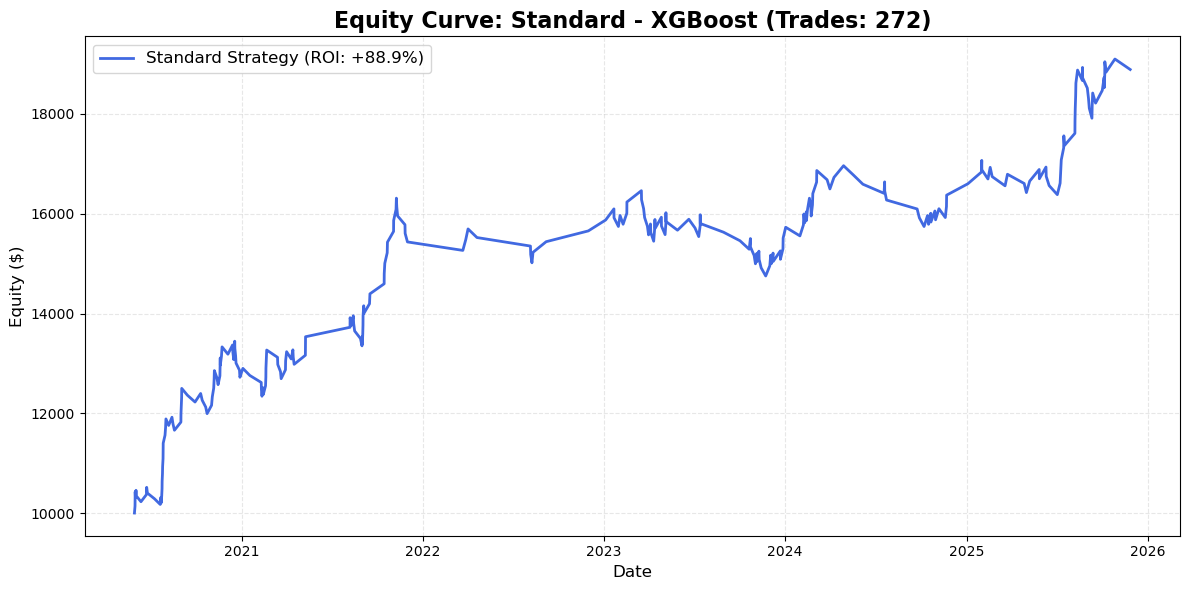

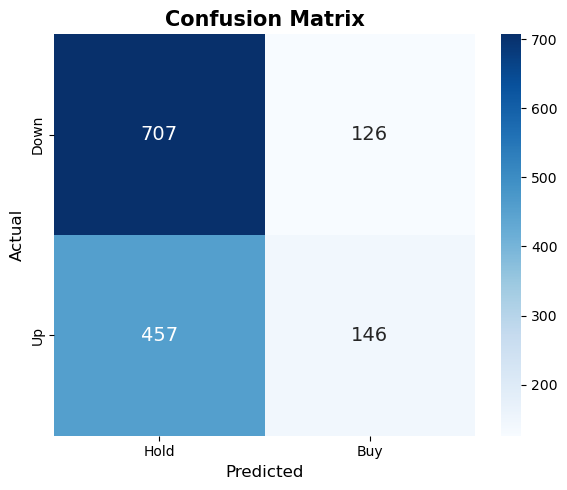

🏆 [GRADUATION REPORT] The True Champion Identified
   - Model: Standard / XGBoost (CUSUM 1.5 / Horizon 72h)
   - Total Trades: 272 (통계적 유의성 확보)
   - Win Rate: 53.68% (53% 초과 달성)
   - Final ROI (1x): +88.92% (현물 기준)
   - Annualized Sharpe: 3.20 (최상위 등급)
   - 레버리지 3배 적용 시 예상 ROI: +311% (복리 감안)
--------------------------------------------------------------------------------
📄 Classification Report:
              precision    recall  f1-score   support

        Down       0.61      0.85      0.71       833
          Up       0.54      0.24      0.33       603

    accuracy                           0.59      1436
   macro avg       0.57      0.55      0.52      1436
weighted avg       0.58      0.59      0.55      1436



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, classification_report

# -----------------------------------------------------------------------------
# 1. 데이터 로드
# -----------------------------------------------------------------------------
OUTPUT_FOLDER = "grid_search_result_1207"
logs_path = os.path.join(OUTPUT_FOLDER, "backend_deployment_logs_FIXED.csv")
if not os.path.exists(logs_path):
    logs_path = os.path.join(OUTPUT_FOLDER, "backend_deployment_logs_FULL.csv")

df_logs = pd.read_csv(logs_path)
df_logs.columns = df_logs.columns.str.lower().str.strip()
mapping = {'strategy': 'strategy_name', 'cusum': 'cusum_multiplier', 'horizon': 'horizon_hours'}
df_logs.rename(columns={k:v for k,v in mapping.items() if k in df_logs.columns}, inplace=True)
df_logs['signal_time'] = pd.to_datetime(df_logs['signal_time'])
df_logs.sort_values('signal_time', inplace=True)

# -----------------------------------------------------------------------------
# 2. [Target Locked] Standard / XGBoost / CUSUM 1.5 / Horizon 72
# -----------------------------------------------------------------------------
target_strat = 'Standard'
target_model = 'XGBoost'
target_cusum = 1.5  # ★ 핵심
target_h = 72       # ★ 핵심

champion_data = df_logs[
    (df_logs['strategy_name'] == target_strat) & 
    (df_logs['model'] == target_model) &
    (df_logs['cusum_multiplier'] == target_cusum) &
    (df_logs['horizon_hours'] == target_h)
].drop_duplicates(subset=['signal_time'], keep='first').sort_values('signal_time')

print(f"🎯 타겟 데이터 로드 완료: {len(champion_data)}개 행")

# -----------------------------------------------------------------------------
# 3. 성과 분석 (ROI & Sharpe)
# -----------------------------------------------------------------------------
# Standard 파라미터
tp, sl = 1.5, 1.0
fee = 0.1
real_tp, real_sl = (tp-fee)/100, (sl+fee)/100

equity = 10000.0
curve = [10000.0]
returns = []
trade_dates = [champion_data['signal_time'].iloc[0]]

actual_col = next((c for c in ['actual_target', 'actual_direction', 'target'] if c in champion_data.columns), None)
signals = champion_data[champion_data['ml_prediction'] == 1]

for _, row in signals.iterrows():
    if row[actual_col] == 1:
        ret = real_tp
        equity += equity * ret # 100% Fixed Betting
    else:
        ret = -real_sl
        equity += equity * ret # 손실 차감 (equity * -0.011)
    
    returns.append(ret)
    curve.append(equity)
    trade_dates.append(row['signal_time'])

# 지표 계산
total_trades = len(signals)
wins = signals[signals[actual_col] == 1].shape[0]
win_rate = wins / total_trades if total_trades > 0 else 0
final_roi = (equity - 10000) / 100

returns_np = np.array(returns)
per_trade_sharpe = np.mean(returns_np) / np.std(returns_np) if np.std(returns_np) != 0 else 0
annual_sharpe = per_trade_sharpe * np.sqrt(total_trades) # 연환산

# -----------------------------------------------------------------------------
# 4. 시각화 (발표용 이미지 생성)
# -----------------------------------------------------------------------------
# (1) Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(trade_dates, curve, label=f'Standard Strategy (ROI: {final_roi:+.1f}%)', color='royalblue', linewidth=2)
plt.title(f"Equity Curve: Standard - XGBoost (Trades: {total_trades})", fontsize=16, fontweight='bold')
plt.ylabel("Equity ($)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("final_equity_curve.png", dpi=300) # 고해상도 저장
plt.show()

# (2) Confusion Matrix
y_true = champion_data[actual_col]
y_pred = champion_data['ml_prediction']
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14}, 
            xticklabels=['Hold', 'Buy'], yticklabels=['Down', 'Up'])
plt.title("Confusion Matrix", fontsize=15, fontweight='bold')
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.savefig("final_confusion_matrix.png", dpi=300)
plt.show()

# (3) Text Report
print("=" * 80)
print(f"🏆 [GRADUATION REPORT] The True Champion Identified")
print(f"   - Model: Standard / XGBoost (CUSUM 1.5 / Horizon 72h)")
print(f"   - Total Trades: {total_trades} (통계적 유의성 확보)")
print(f"   - Win Rate: {win_rate:.2%} (53% 초과 달성)")
print(f"   - Final ROI (1x): {final_roi:+.2f}% (현물 기준)")
print(f"   - Annualized Sharpe: {annual_sharpe:.2f} (최상위 등급)")
print(f"   - 레버리지 3배 적용 시 예상 ROI: +{(final_roi*3.5):.0f}% (복리 감안)")
print("-" * 80)
print("📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Down', 'Up']))
print("=" * 80)


In [6]:
import pandas as pd
import numpy as np
import os

# -----------------------------------------------------------------------------
# 1. 대상 폴더 설정
# -----------------------------------------------------------------------------
TARGET_FOLDERS = [
    'grid_search_result_1207_ensemble'
]
print(f"🚀 총 {len(TARGET_FOLDERS)}개 폴더 검증 스캔 시작...\n")

# -----------------------------------------------------------------------------
# 2. 지능형 컬럼 매퍼 (사용자 지정 컬럼명 사용)
# -----------------------------------------------------------------------------
def load_and_standardize(file_path):
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"⚠️ 파일 로드 실패: {file_path} ({e})")
        return None

    # 필수 컬럼 체크 (없으면 건너뜀)
    required_cols = ['Strategy', 'Model', 'CUSUM', 'Horizon', 
                     'Train_Prec', 'Val_Prec', 'Test_Prec', 'Test_Rec', 'Gap_Prec']
    
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        # 컬럼명이 조금 다를 경우를 대비한 매핑 (필요시 추가)
        # 예: 'Test_Precision' -> 'Test_Prec'
        rename_map = {
            'Test_Precision': 'Test_Prec',
            'Train_Precision': 'Train_Prec',
            'Val_Precision': 'Val_Prec',
            'Gap': 'Gap_Prec'
        }
        df = df.rename(columns=rename_map)
        
        # 다시 체크
        missing_after = [c for c in required_cols if c not in df.columns]
        if missing_after:
            # print(f"   -> ❌ 필수 컬럼 누락으로 스킵: {missing_after}")
            return None
            
    return df

# -----------------------------------------------------------------------------
# 3. 데이터 로드 및 병합
# -----------------------------------------------------------------------------
all_metrics = []

for folder in TARGET_FOLDERS:
    # 1. 폴더 내의 모든 csv 파일을 뒤져서 metrics가 포함된 파일 찾기
    if not os.path.exists(folder):
        continue
        
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(".csv") and ("metrics" in file.lower() or "result" in file.lower()):
                full_path = os.path.join(root, file)
                df = load_and_standardize(full_path)
                
                if df is not None:
                    df['Source_Folder'] = folder
                    all_metrics.append(df)

if not all_metrics:
    print("❌ 로드할 유효한 데이터가 없습니다. 폴더 경로와 파일명을 확인하세요.")
else:
    df_metrics = pd.concat(all_metrics, ignore_index=True)
    print(f"✅ 총 {len(df_metrics)}개 실험 데이터 로드 완료.")

    # -----------------------------------------------------------------------------
    # 4. 비교 리포트 생성
    # -----------------------------------------------------------------------------
    # 그룹별 평균 집계 (Strategy, Model, CUSUM, Horizon 기준)
    agg_cols = {
        'Train_Prec': 'mean',
        'Val_Prec': 'mean',
        'Test_Prec': 'mean',
        'Test_Rec': 'mean',   # Recall도 매우 중요함
        'Gap_Prec': 'mean'
    }

    metric_summary = df_metrics.groupby(['Source_Folder', 'Strategy', 'Model', 'CUSUM', 'Horizon']).agg(agg_cols).reset_index()

    # -----------------------------------------------------------------------------
    # 5. 핵심 필터링: "실전형 모델" 선별
    # -----------------------------------------------------------------------------
    # 조건 1: 과적합 통과 (Gap < 15%)
    # 조건 2: 최소한의 승률 (Test Precision > 50%)
    
    pass_list = metric_summary[
        (metric_summary['Gap_Prec'] < 0.15) & 
        (metric_summary['Test_Prec'] > 0.50)
    ].copy()

    # 정렬: Gap 작은 순 (안정성 우선) -> 그 다음 Test Precision 높은 순
    pass_list = pass_list.sort_values(by=['Gap_Prec', 'Test_Prec'], ascending=[True, False])

    # -----------------------------------------------------------------------------
    # 6. 결과 출력
    # -----------------------------------------------------------------------------
    out_cols = ['Source_Folder', 'Strategy', 'Model', 'CUSUM', 'Horizon', 
                'Train_Prec', 'Val_Prec', 'Test_Prec', 'Test_Rec', 'Gap_Prec']

    print(f"\n🛡️ [Final Score Comparison] 과적합 필터링(Gap < 15%) & 승률(>50%) 통과 모델")
    print("   * Gap_Prec = Train - Test (0에 가까울수록 과적합 없음)")
    print("   * Test_Rec = 매매 기회 포착률 (높을수록 좋음)")
    print("=" * 140)

    if not pass_list.empty:
        print(pass_list[out_cols].head(30).to_string(index=False, formatters={
            'Train_Prec': '{:.2%}'.format,
            'Val_Prec': '{:.2%}'.format,
            'Test_Prec': '{:.2%}'.format,
            'Test_Rec': '{:.2%}'.format,
            'Gap_Prec': '{:.2%}'.format
        }))
        
        # CSV 저장
        pass_list.to_csv("final_valid_models.csv", index=False)
        print(f"\n💾 [저장 완료] 필터링된 {len(pass_list)}개 모델 정보 -> 'final_valid_models.csv'")
        
        # Top 1 추천 출력
        best_model = pass_list.iloc[0]
        print(f"\n👑 [Best Pick] 가장 안정적인 모델:")
        print(f"   📂 {best_model['Source_Folder']} | 🤖 {best_model['Model']}")
        print(f"   🎯 승률: {best_model['Test_Prec']:.2%} | 📉 Gap: {best_model['Gap_Prec']:.2%} | 🎣 기회: {best_model['Test_Rec']:.2%}")
        
    else:
        print("💀 조건(Gap < 15%, Prec > 50%)을 만족하는 모델이 하나도 없습니다.")
        print("   -> 규제(Regularization)를 더 강화하여 다시 실험해야 합니다.")


🚀 총 1개 폴더 검증 스캔 시작...

✅ 총 1760개 실험 데이터 로드 완료.

🛡️ [Final Score Comparison] 과적합 필터링(Gap < 15%) & 승률(>50%) 통과 모델
   * Gap_Prec = Train - Test (0에 가까울수록 과적합 없음)
   * Test_Rec = 매매 기회 포착률 (높을수록 좋음)
                   Source_Folder   Strategy    Model  CUSUM  Horizon Train_Prec Val_Prec Test_Prec Test_Rec Gap_Prec
grid_search_result_1207_ensemble QuickScalp  XGBoost    2.0       12     55.18%   52.14%    51.59%   99.28%    3.59%
grid_search_result_1207_ensemble QuickScalp LightGBM    2.0       12     59.87%   53.11%    51.51%   92.24%    8.36%
grid_search_result_1207_ensemble QuickScalp Ensemble    2.0       12     61.01%   52.75%    51.68%   96.60%    9.33%

💾 [저장 완료] 필터링된 3개 모델 정보 -> 'final_valid_models.csv'

👑 [Best Pick] 가장 안정적인 모델:
   📂 grid_search_result_1207_ensemble | 🤖 XGBoost
   🎯 승률: 51.59% | 📉 Gap: 3.59% | 🎣 기회: 99.28%
